# Chapter 16: Bayesian statistics

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://link.springer.com/book/10.1007/979-8-8688-0413-7) (ISBN 979-8-8688-0412-0).

In [1]:
import pymc as mc 

In [2]:
import numpy as np

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set()

In [5]:
from scipy import stats

In [6]:
import statsmodels.api as sm

In [7]:
import statsmodels.formula.api as smf

In [8]:
import pandas as pd

## Changelog:

* 160828: The keyword argument `vars` to the functions `mc.traceplot` and `mc.forestplot` was changed to `varnames`.
* 231125: The keyword `varnames` was changed to `var_names`

# Simple example: Normal distributed random variable

In [9]:
# try this
# dir(mc.distributions)

In [10]:
np.random.seed(100)

In [11]:
mu = 4.0

In [12]:
sigma = 2.0

In [13]:
model = mc.Model()

In [14]:
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [15]:
model.continuous_value_vars

[X]

In [16]:
start = dict(X=2)

In [17]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, initvals=start)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.


In [18]:
x = np.linspace(-4, 12, 1000)

In [19]:
y = stats.norm(mu, sigma).pdf(x)

In [20]:
# import arviz as az

In [21]:
# az.extract(trace)

In [22]:
def get_values(trace, variable):
    return trace.posterior.stack(sample=['chain', 'draw'])[variable].values

In [23]:
X = get_values(trace, "X")

In [24]:
X

array([0.91674571, 1.33214833, 1.33214833, ..., 5.3859442 , 5.3859442 ,
       4.39995454])

/Users/rob/miniconda3/envs/npm_v2_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rob/miniconda3/envs/npm_v2_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


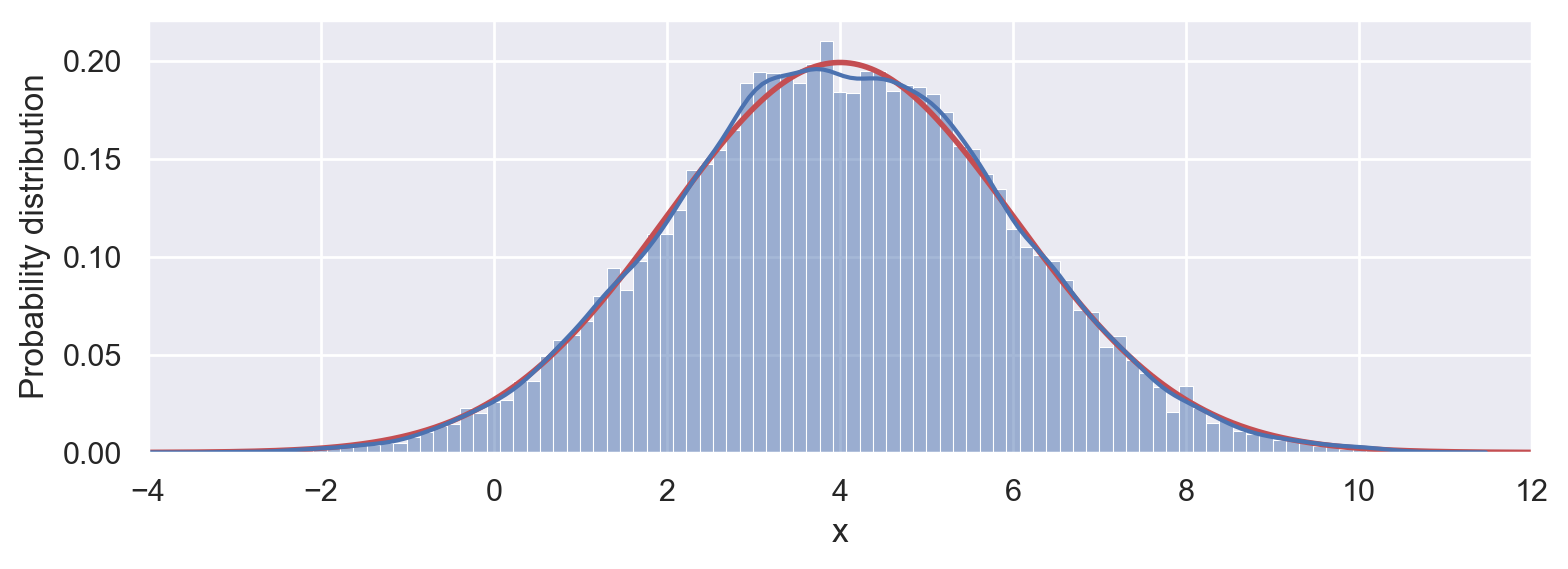

In [25]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.histplot(X, ax=ax, kde=True, stat='density')
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-normal-distribution-sampled.pdf")
fig.savefig("ch16-normal-distribution-sampled.png", dpi=600)

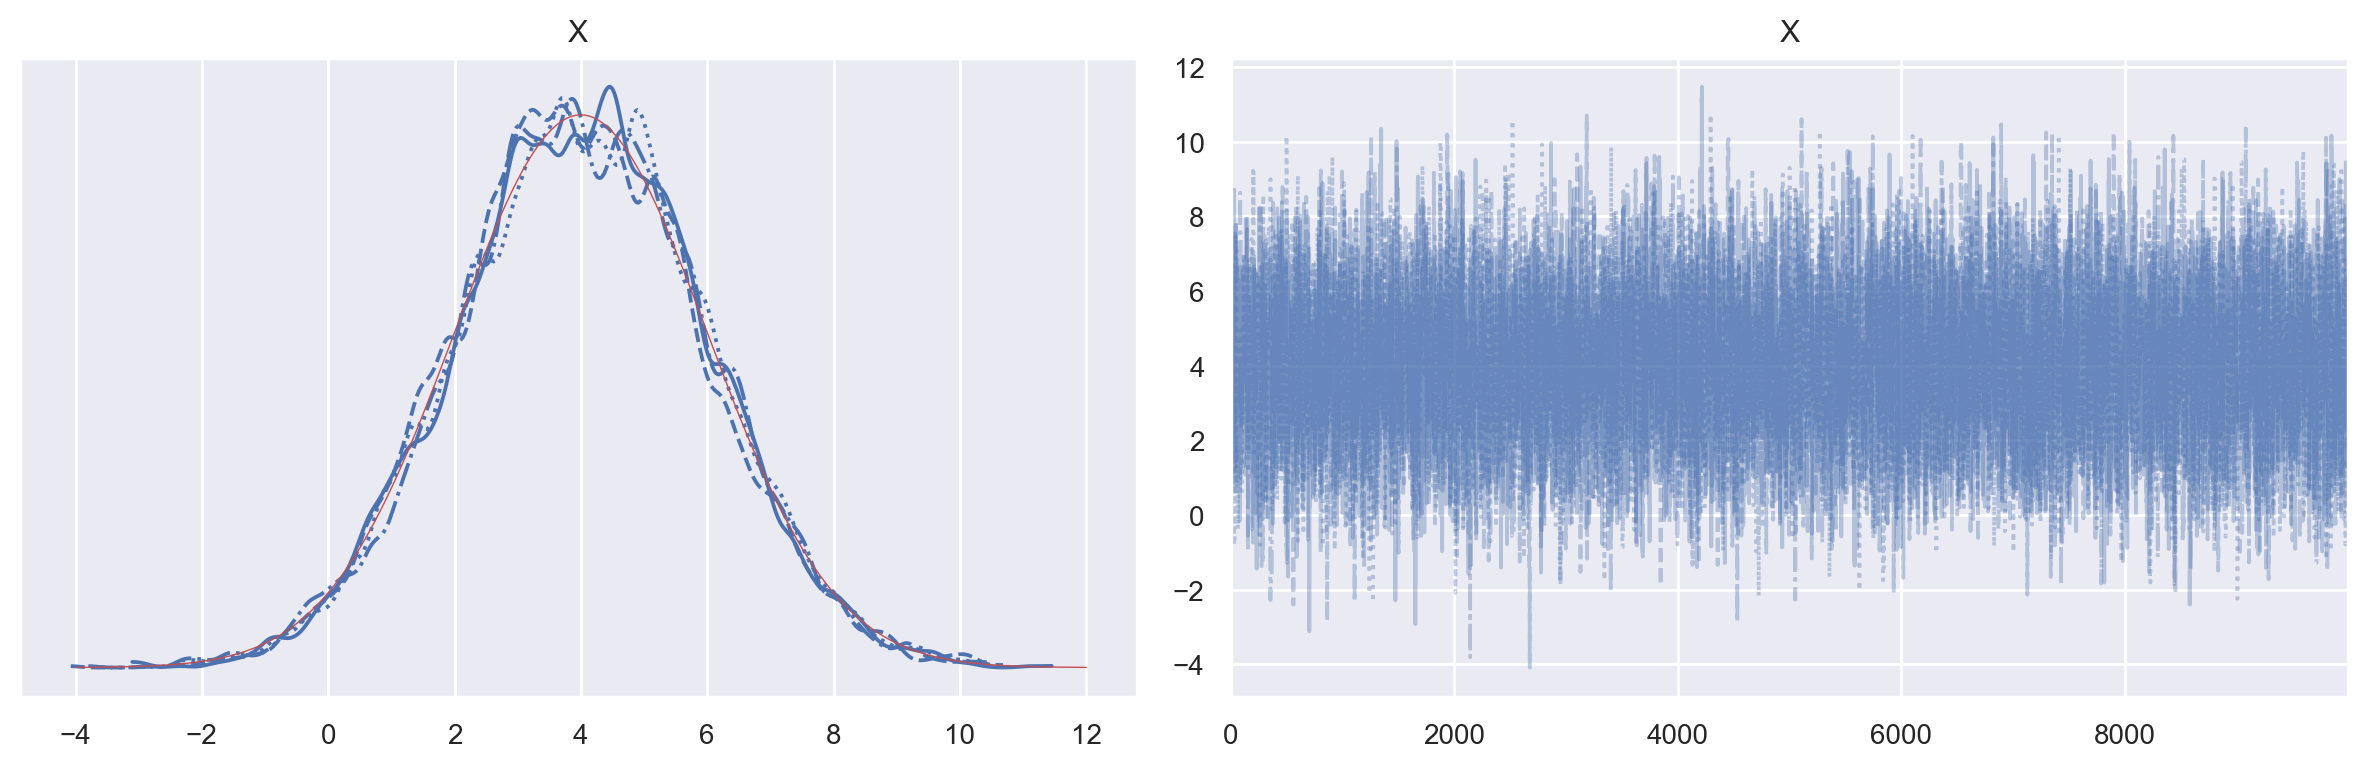

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
mc.plot_trace(trace, axes=axes)
axes[0,0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()
fig.savefig("ch16-normal-sampling-trace.png", dpi=600)
fig.savefig("ch16-normal-sampling-trace.pdf")

## Dependent random variables

In [27]:
model = mc.Model()

In [28]:
#mc.HalfNormal??

In [29]:
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sigma=1.0)
    X = mc.Normal('X', mean, tau=sigma)

In [30]:
model.continuous_value_vars

[mean, sigma_log__, X]

In [31]:
with model:
    start = mc.find_MAP()

In [32]:
start

{'mean': array(2.99999901),
 'sigma_log__': array(-0.34657378),
 'X': array(3.00000036),
 'sigma': array(0.70710665)}

In [33]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, initvals=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mean]
>Metropolis: [sigma]
>Metropolis: [X]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.


In [34]:
get_values(trace, "sigma").mean()

0.7921961542294592

In [35]:
X = get_values(trace, "X")

In [36]:
X.mean()

2.9634882470897166

In [37]:
X.std()

2.4832085341157826

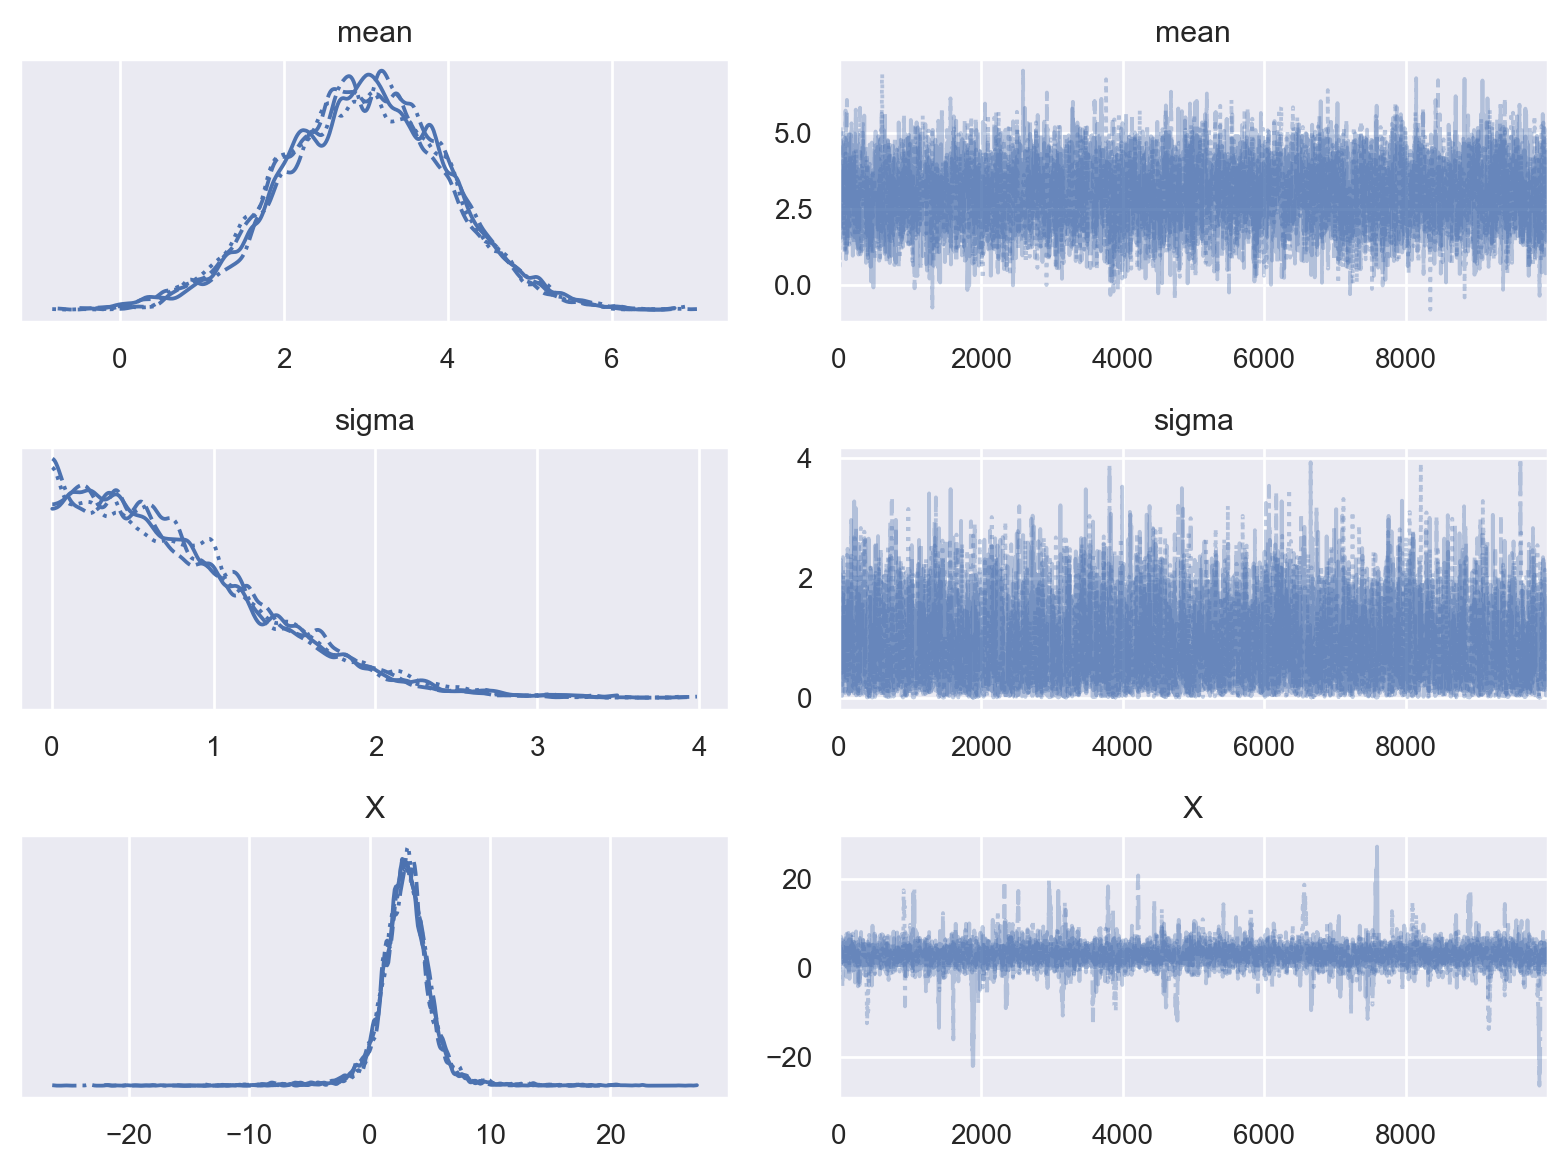

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.plot_trace(trace, var_names=['mean', 'sigma', 'X'], axes=axes)
fig.tight_layout()
fig.savefig("ch16-dependent-rv-sample-trace.png", dpi=600)
fig.savefig("ch16-dependent-rv-sample-trace.pdf")

## Posterior distributions

In [39]:
mu = 2.5

In [40]:
s = 1.5

In [41]:
data = stats.norm(mu, s).rvs(100)

In [42]:
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, tau=1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', tau=3.0 * np.sqrt(np.pi/2)) # true 1.5

    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data)

In [43]:
model.continuous_value_vars

[mean, sigma_log__]

In [44]:
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(10000, initvals=start, step=step)
    #step = mc.NUTS()
    #trace = mc.sample(10000, initvals=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mean]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.


In [45]:
start

{'mean': array(2.37576359),
 'sigma_log__': array(0.33924884),
 'sigma': array(1.40389264)}

In [46]:
model.continuous_value_vars

[mean, sigma_log__]

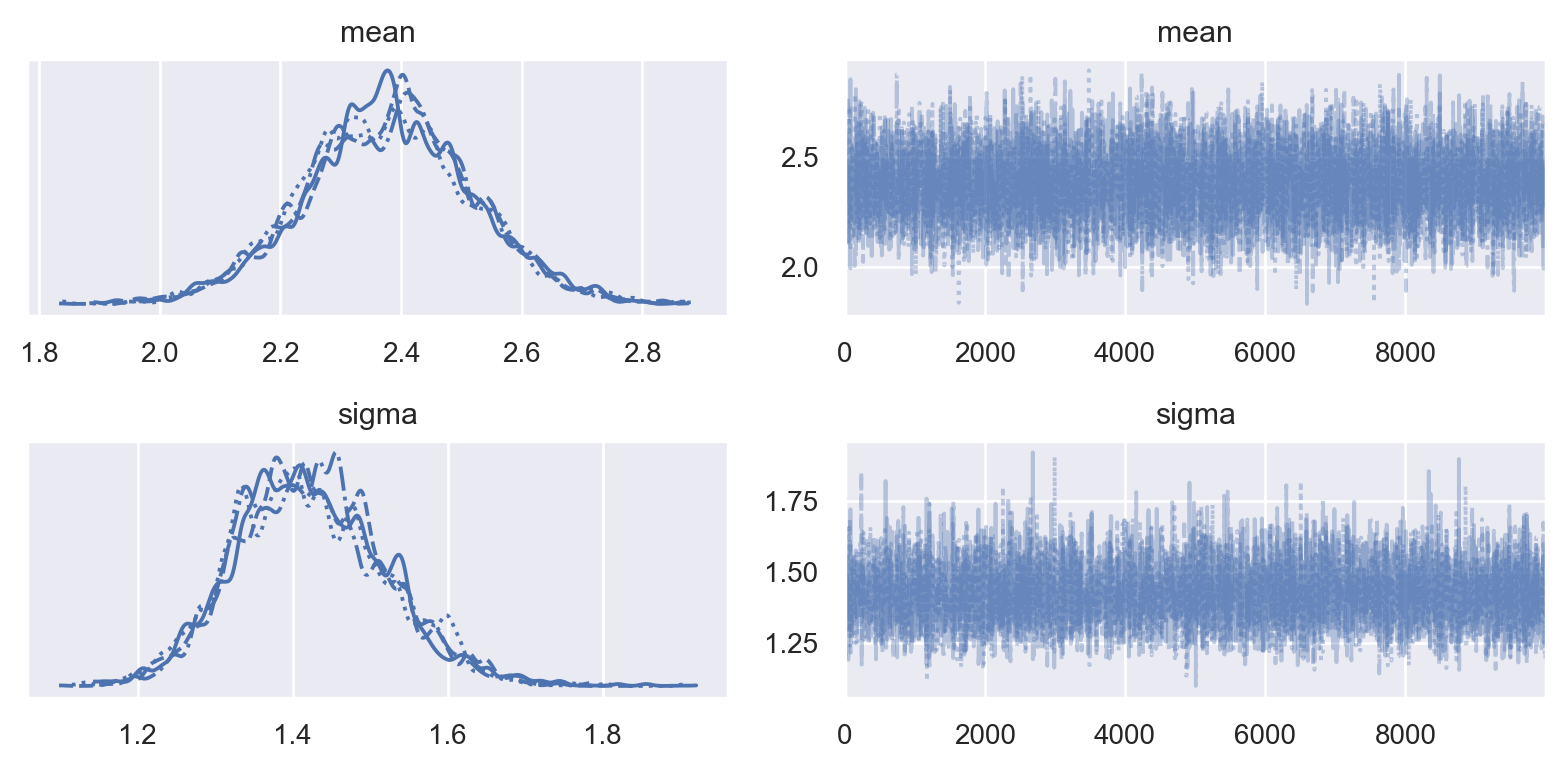

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.plot_trace(trace, var_names=['mean', 'sigma'], axes=axes)
fig.tight_layout()
fig.savefig("ch16-posterior-sample-trace.png", dpi=600)
fig.savefig("ch16-posterior-sample-trace.pdf")

In [49]:
mu, get_values(trace, "mean").mean() # trace.posterior.stack(sample=['chain', 'draw'])["mean"]

(2.5, 2.3792045174809107)

In [50]:
s, get_values(trace, "sigma").mean() # trace.posterior.stack(sample=['chain', 'draw'])["sigma"].values.mean()

(1.5, 1.4228102333583557)

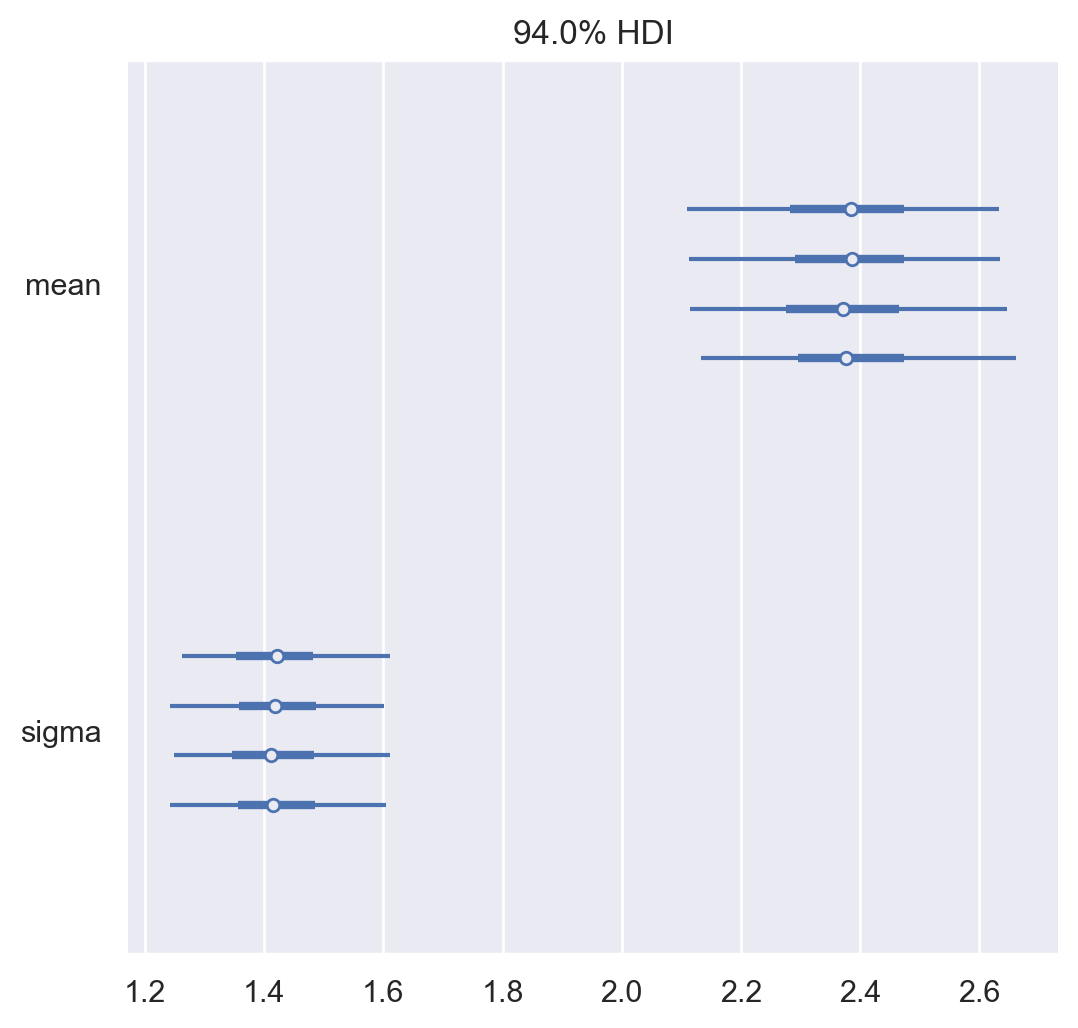

In [51]:
gs = mc.plot_forest(trace, var_names=['mean', 'sigma'])
plt.savefig("ch16-forestplot.pdf")
plt.savefig("ch16-forestplot.png", dpi=600)

In [52]:
# help(mc.summary)

In [53]:
mc.summary(trace, var_names=['mean', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mean   2.379  0.140   2.106    2.635      0.002    0.001    6567.0    6587.0   
sigma  1.423  0.097   1.246    1.605      0.001    0.001    4938.0    5297.0   

       r_hat  
mean     1.0  
sigma    1.0

## Linear regression

In [54]:
dataset = sm.datasets.get_rdataset("Davis", "carData", cache=True)

In [55]:
data = dataset.data[dataset.data.sex == 'M']

In [56]:
data = data[data.weight < 110]

In [57]:
data.head(3)

sex  weight  height  repwt  repht
0   M      77     182   77.0  180.0
3   M      68     177   70.0  175.0
5   M      76     170   76.0  165.0

In [58]:
model = smf.ols("height ~ weight", data=data)

In [59]:
result = model.fit()

In [60]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     41.35
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           7.11e-09
Time:                        09:44:53   Log-Likelihood:                -268.20
No. Observations:                  87   AIC:                             540.4
Df Residuals:                      85   BIC:                             545.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.6173      3.987     38.281      0.0

In [61]:
x = np.linspace(50, 110, 25)

In [62]:
y = result.predict({"weight": x})

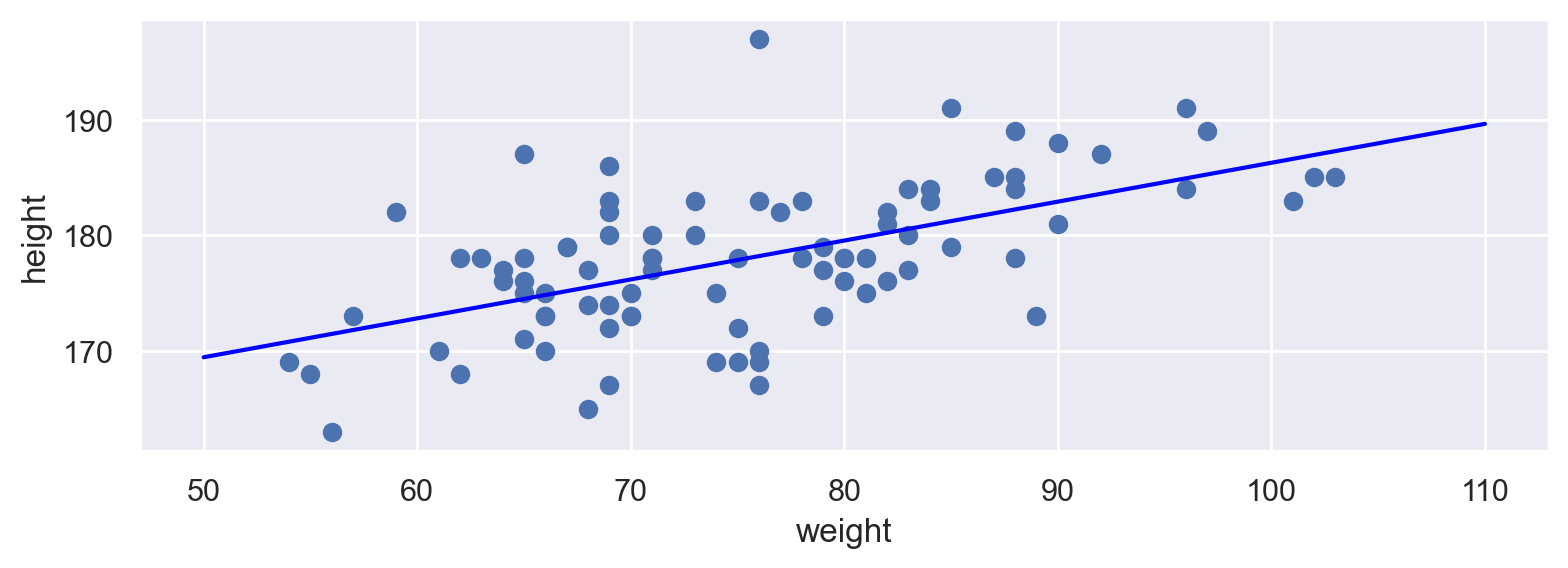

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()
fig.savefig("ch16-linear-ols-fit.pdf")
fig.savefig("ch16-linear-ols-fit.png", dpi=600)

In [64]:
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sigma=30)
    beta = mc.Normal('beta', 0, sigma=5)
    
    height_mu = intercept + beta * data.weight

    # likelihood function
    mc.Normal('height', mu=height_mu, sigma=sigma, observed=data.height)

    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sigma=sigma, shape=len(x)) 

In [65]:
model.continuous_value_vars

[sigma_interval__, intercept, beta, predict_height]

In [66]:
# help(mc.NUTS)

In [67]:
with model:
    # start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step=step) # , initvals=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta, predict_height]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 139 seconds.


In [68]:
model.continuous_value_vars

[sigma_interval__, intercept, beta, predict_height]

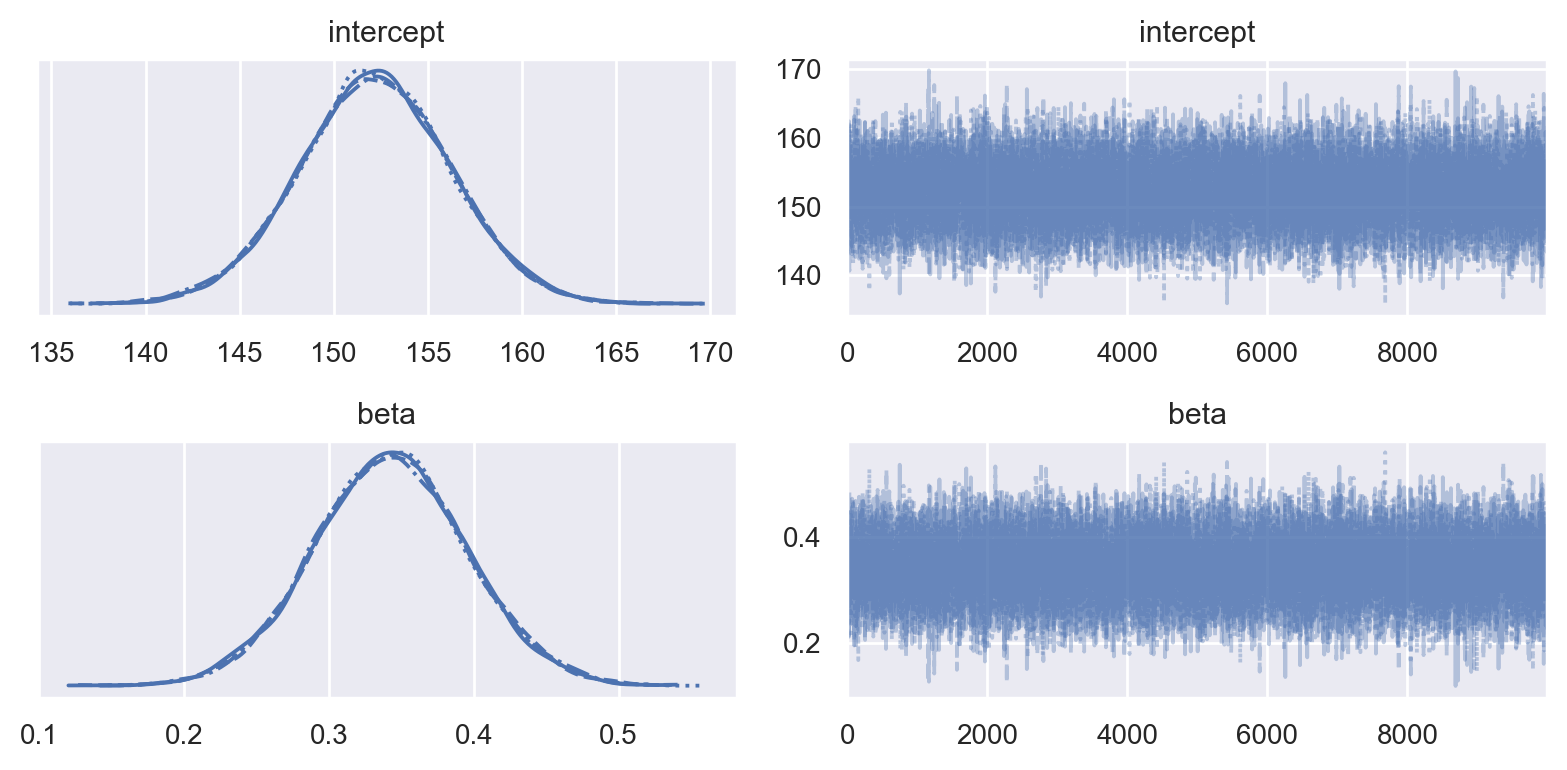

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.plot_trace(trace, var_names=['intercept', 'beta'], axes=axes)
fig.tight_layout()
fig.savefig("ch16-linear-model-sample-trace.pdf")
fig.savefig("ch16-linear-model-sample-trace.png", dpi=600)

In [70]:
intercept = get_values(trace, "intercept").mean()
intercept

152.17013984548987

In [71]:
beta = get_values(trace, "beta").mean() # trace.posterior.stack(sample=['chain', 'draw'])["beta"].values.mean()
beta

0.34229067573612304

In [72]:
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [73]:
result.predict({"weight": 90})

0    182.9003
dtype: float64

In [74]:
weight_index = np.where(x == 90)[0][0]

In [75]:
# trace.posterior.stack(sample=['chain', 'draw'])["predict_height"].values[weight_index, :].mean()
get_values(trace, "predict_height")[weight_index, :].mean()

182.9682840420416

In [76]:
#trace.get_values("predict_height")[:, weight_index].mean()

In [77]:
#trace.posterior.stack(sample=['chain', 'draw'])["predict_height"].values.shape

/Users/rob/miniconda3/envs/npm_v2_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rob/miniconda3/envs/npm_v2_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


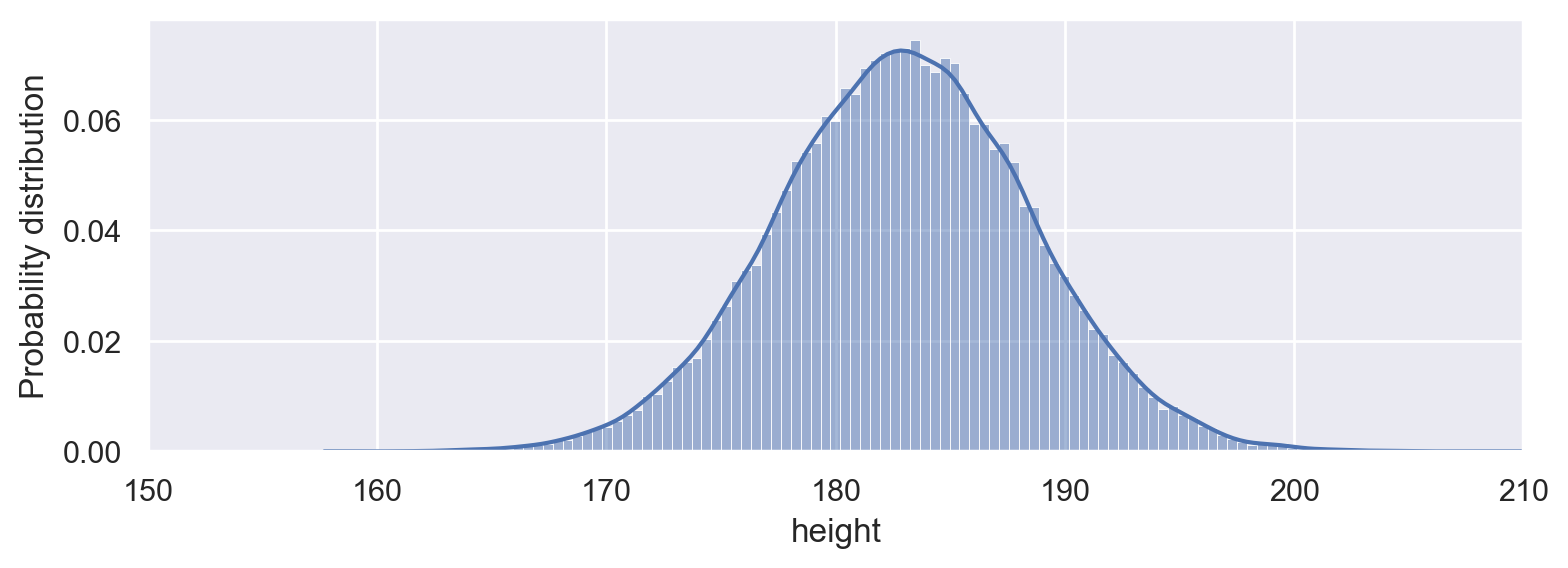

In [78]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.histplot(get_values(trace, "predict_height")[weight_index, :], ax=ax, kde=True, stat='density')
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-linear-model-predict-cut.pdf")
fig.savefig("ch16-linear-model-predict-cut.png", dpi=600)

In [79]:
# trace.posterior.stack(sample=['chain', 'draw'])["intercept"].values

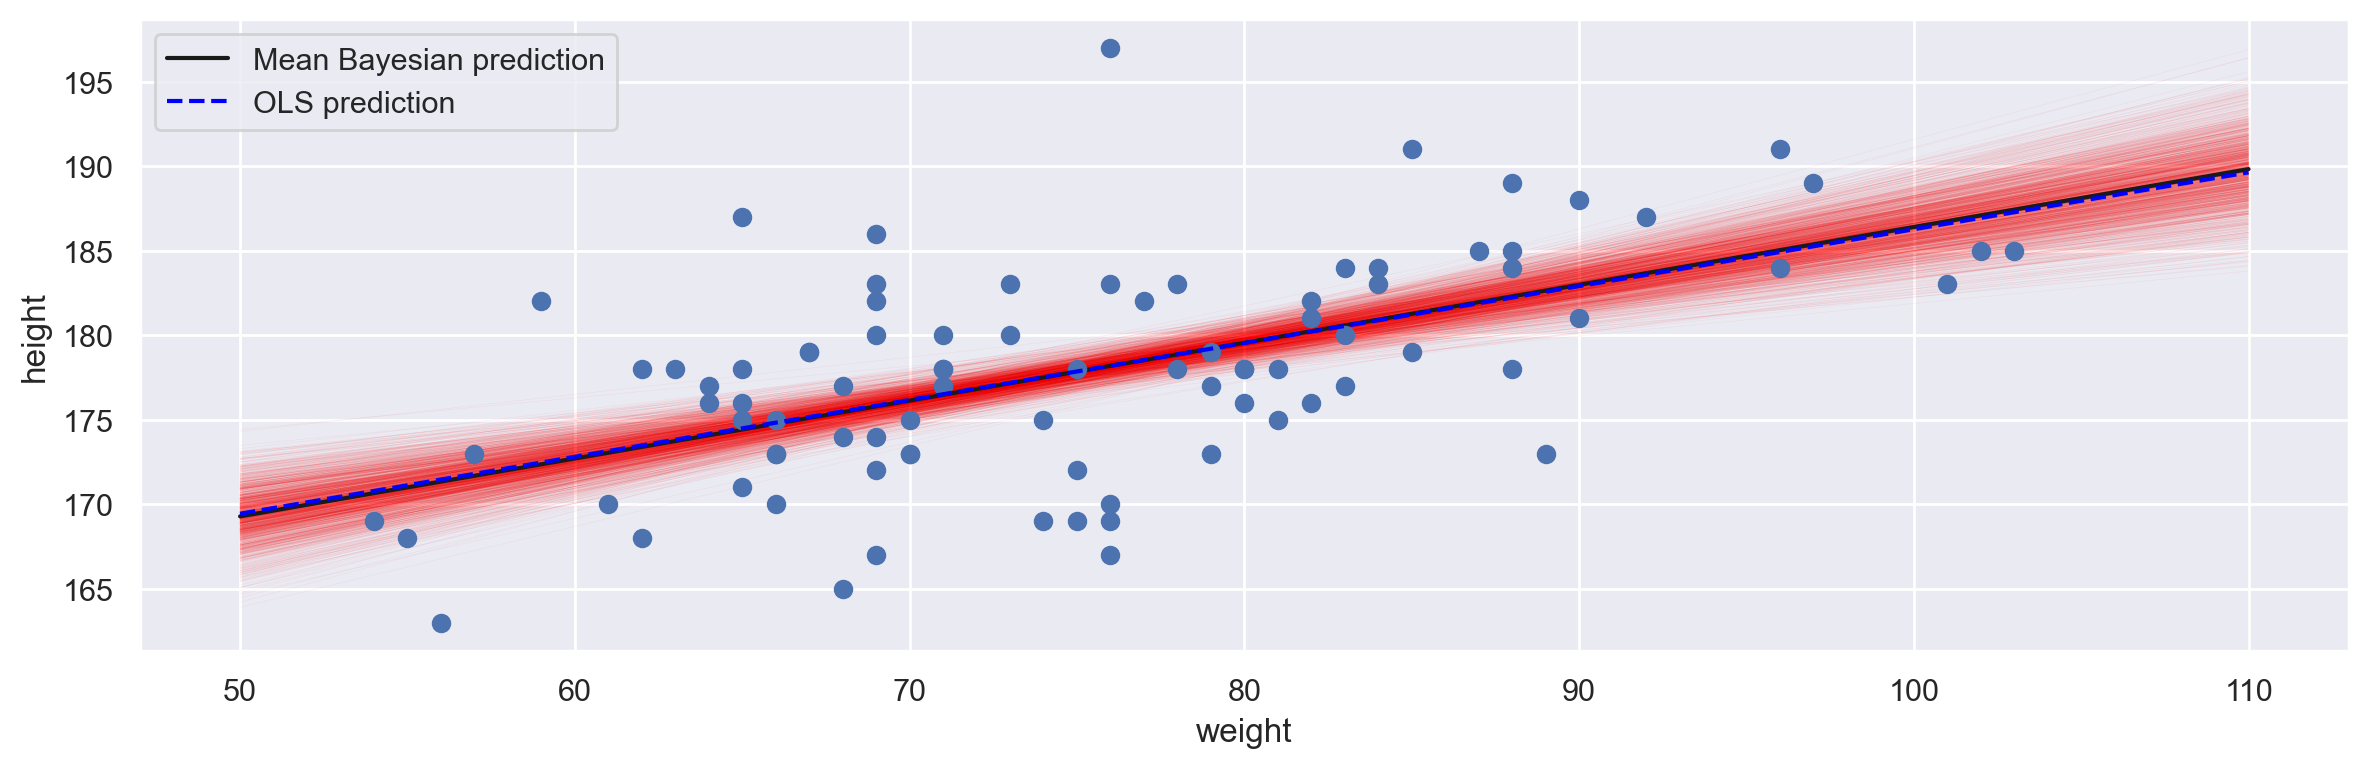

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n in range(500, 2000, 1):
    intercept = get_values(trace, "intercept")[n]
    beta = get_values(trace, "beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = get_values(trace, "intercept").mean()
beta = get_values(trace, "beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-linear-model-fit.pdf")
fig.savefig("ch16-linear-model-fit.png", dpi=600)

In [81]:
import bambi

In [82]:
model = bambi.Model('height ~ weight', data)

In [83]:
trace = model.fit(draws=2000) #  chains=4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height_sigma, Intercept, weight]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


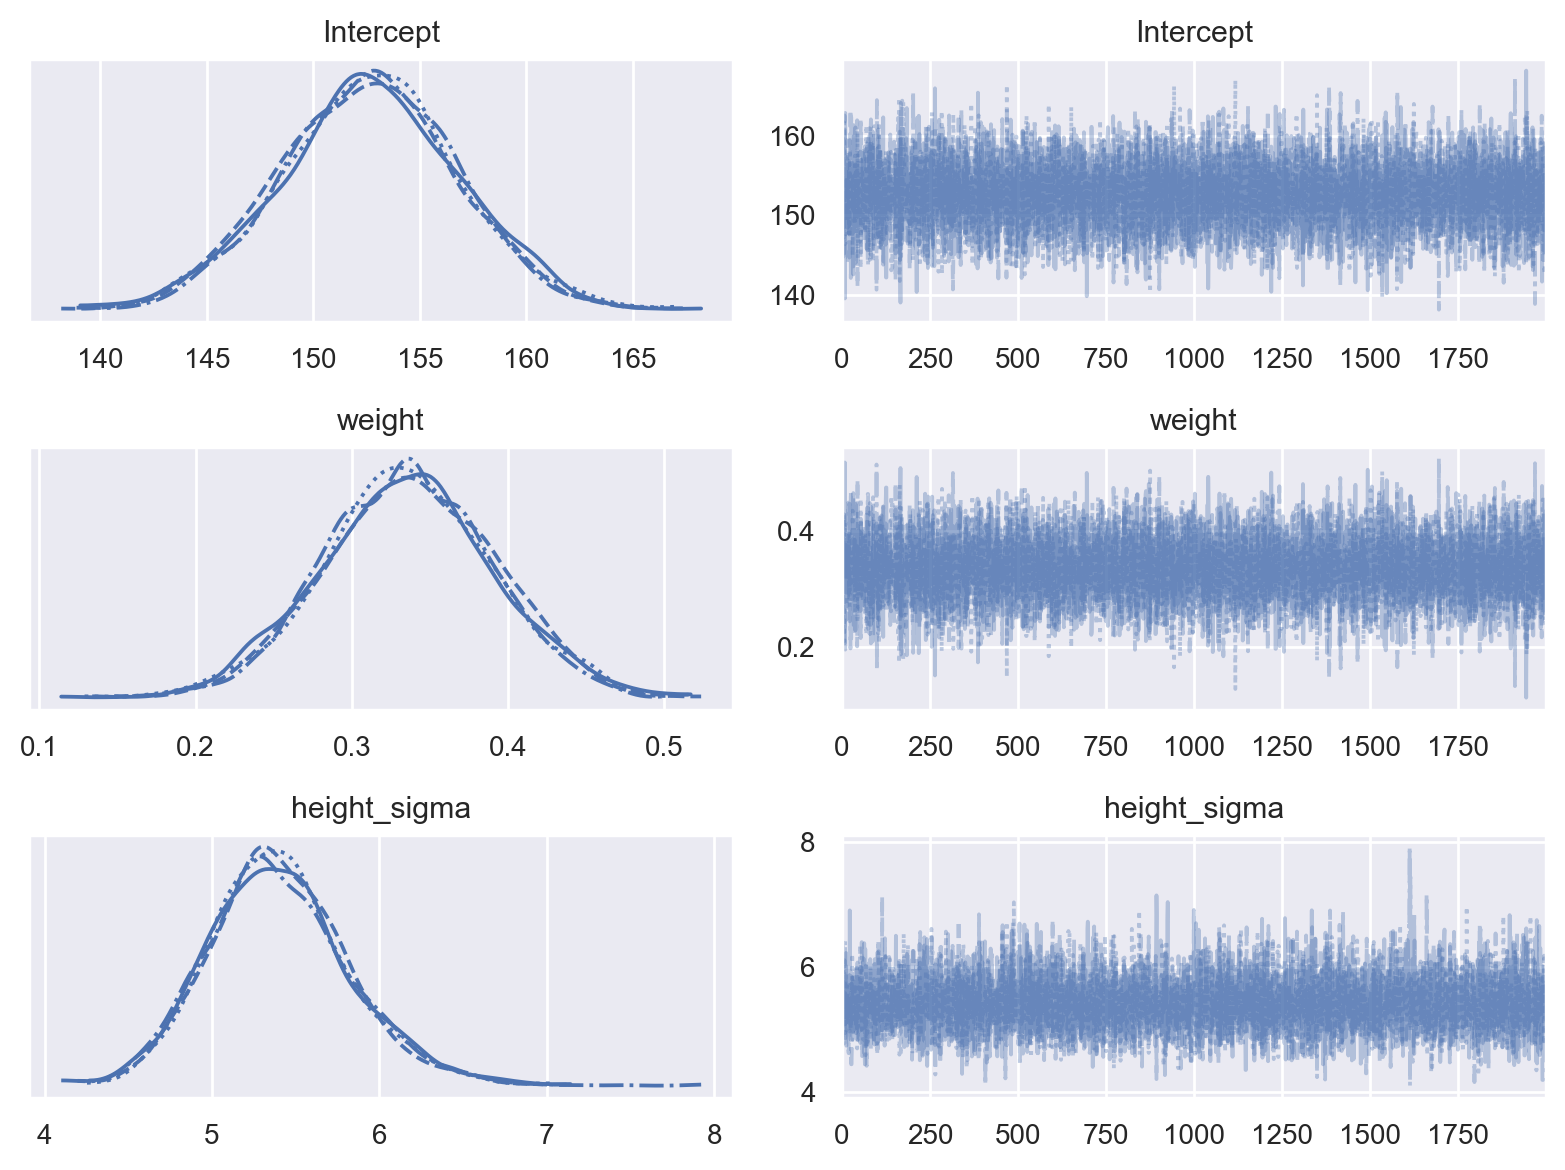

In [84]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.plot_trace(trace, var_names=['Intercept', 'weight', 'height_sigma'], axes=axes)
fig.tight_layout()
fig.savefig("ch16-glm-sample-trace.pdf")
fig.savefig("ch16-glm-sample-trace.png", dpi=600)

## Multilevel model

In [85]:
dataset = sm.datasets.get_rdataset("Davis", "carData", cache=True)

In [86]:
data = dataset.data.copy()
data = data[data.weight < 110]

In [87]:
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)

In [88]:
data.head()

sex  weight  height  repwt  repht
0    0      77     182   77.0  180.0
1    1      58     161   51.0  159.0
2    1      53     161   54.0  158.0
3    0      68     177   70.0  175.0
4    1      59     157   59.0  155.0

In [89]:
with mc.Model() as model:

    # heirarchical model: hyper priors
    #intercept_mu = mc.Normal("intercept_mu", 125)
    #intercept_sigma = 30.0 #mc.Uniform('intercept_sigma', lower=0, upper=50)
    #beta_mu = mc.Normal("beta_mu", 0.0)
    #beta_sigma = 5.0 #mc.Uniform('beta_sigma', lower=0, upper=10)
    
    # multilevel model: prior parameters
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    # priors
    intercept = mc.Normal('intercept', intercept_mu, sigma=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sigma=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    # model equation
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sigma=error, observed=data.height)

In [90]:
model.continuous_value_vars

[intercept, beta, error_interval__]

In [92]:
with model:
    start = mc.find_MAP()
    # hessian = mc.find_hessian(start)
    step = mc.NUTS()
    trace = mc.sample(5000, step=step, initvals=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, error]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 83 seconds.


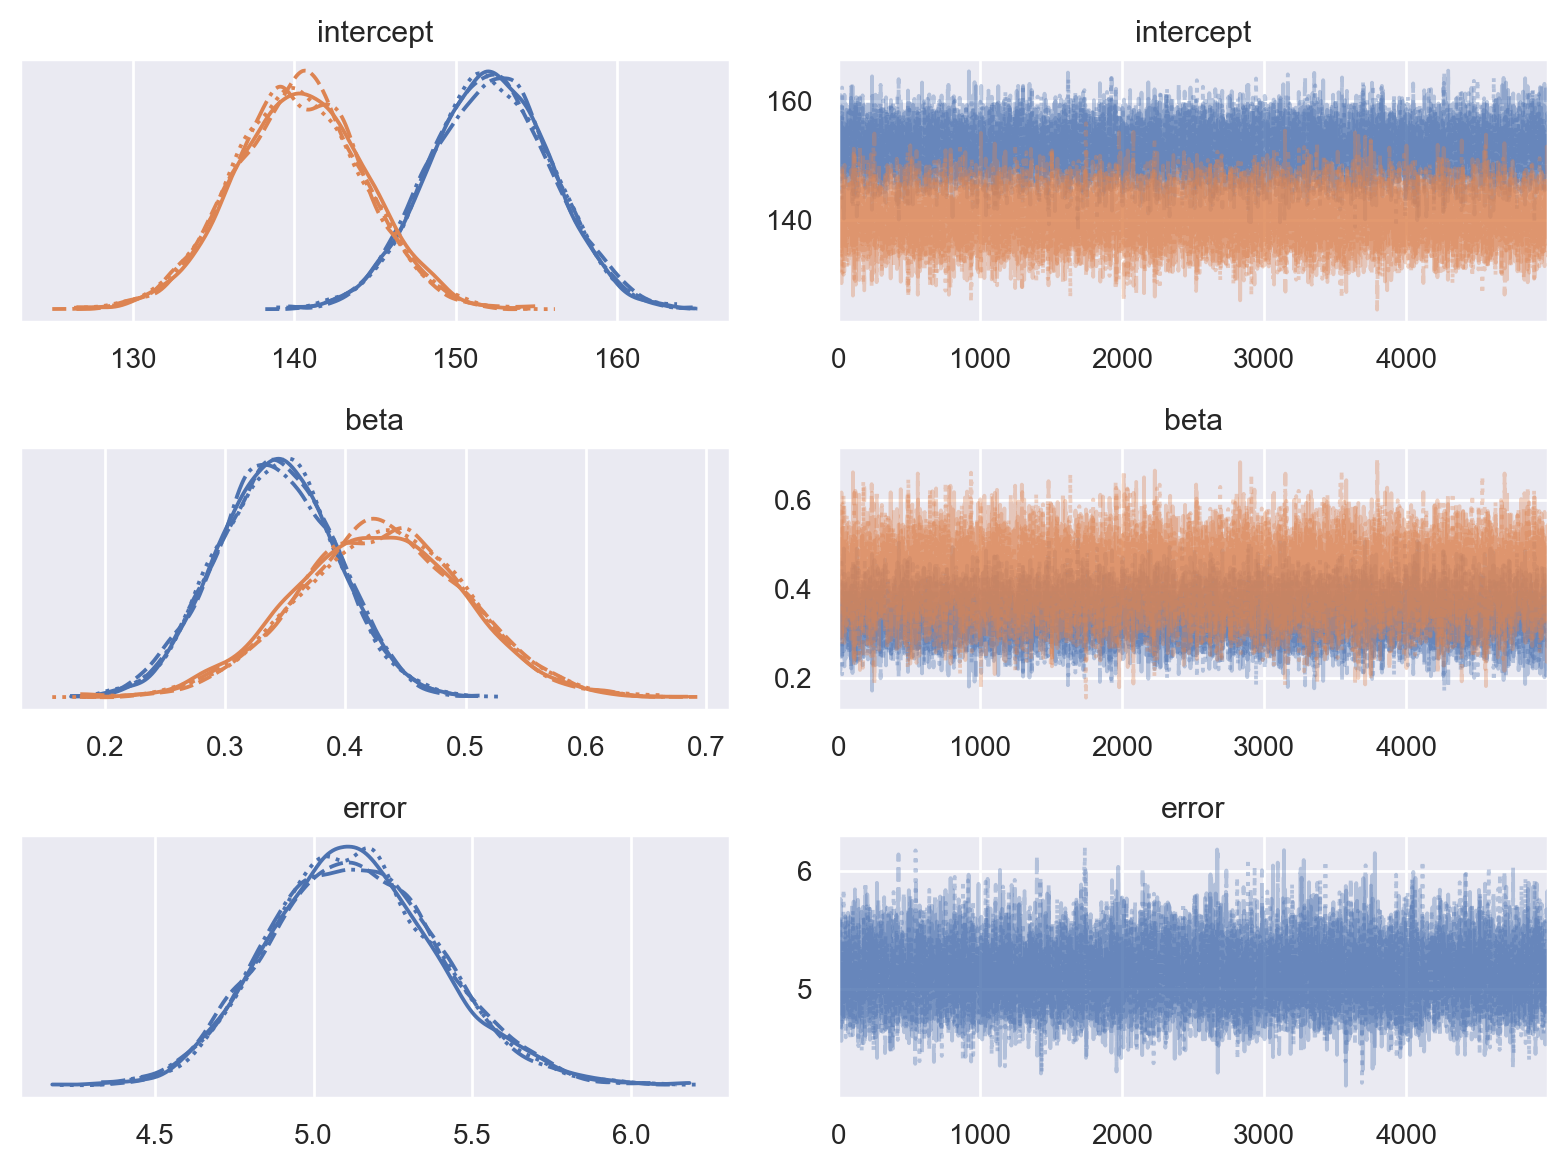

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.plot_trace(trace, var_names=['intercept', 'beta', 'error'], axes=axes)
fig.tight_layout()
fig.savefig("ch16-multilevel-sample-trace.pdf")
fig.savefig("ch16-multilevel-sample-trace.png", dpi=600)

In [94]:
intercept_m, intercept_f = get_values(trace, 'intercept').mean(axis=1)

In [95]:
intercept = get_values(trace, 'intercept').mean()

In [96]:
get_values(trace, 'beta')

array([[0.34194838, 0.29939995, 0.3199544 , ..., 0.35292656, 0.33390056,
        0.31986062],
       [0.30169167, 0.48065079, 0.4321069 , ..., 0.34925651, 0.54491997,
        0.51401649]])

In [97]:
beta_m, beta_f = get_values(trace, 'beta').mean(axis=1)

In [98]:
beta = get_values(trace, 'beta').mean()

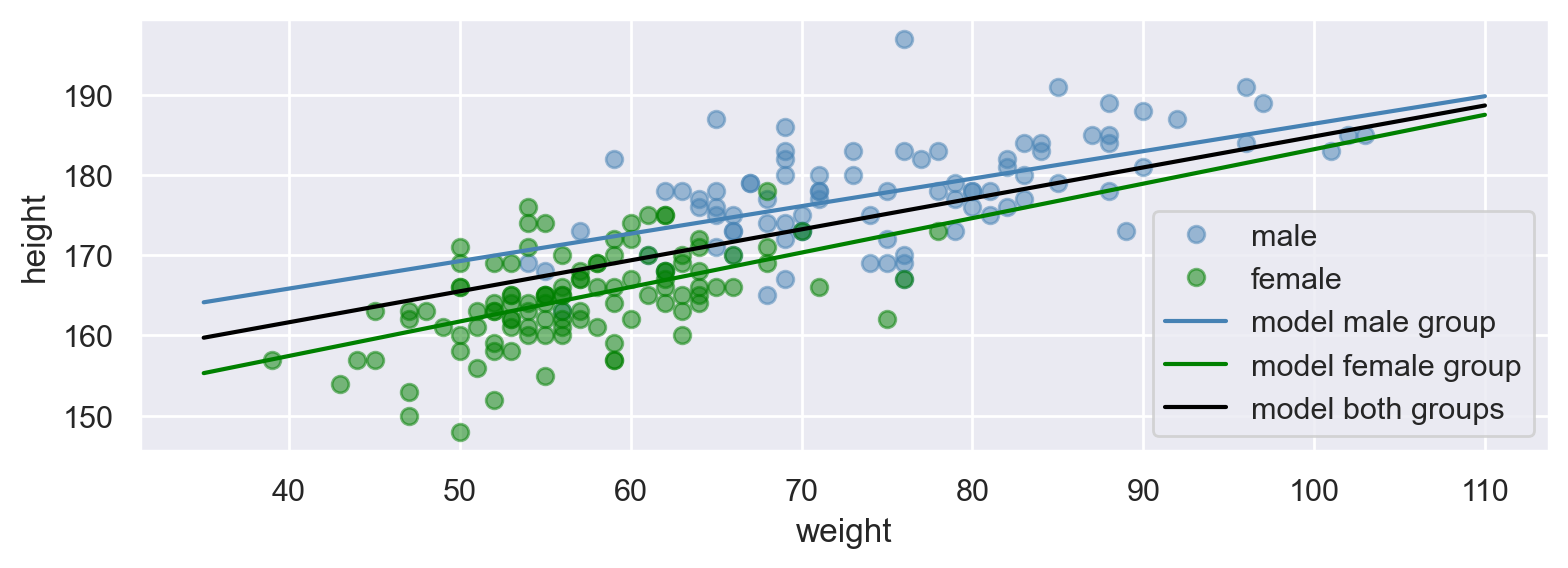

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png", dpi=600)

In [100]:
get_values(trace, 'error').mean()

5.1299582246438336

# Version

In [101]:
%reload_ext version_information

In [102]:
%version_information numpy, pandas, matplotlib, statsmodels, pymc3, theano

Software versions
Python 3.10.13 64bit [Clang 14.0.6 ]
IPython 8.20.0
OS macOS 10.15.7 x86_64 i386 64bit
numpy 1.25.2
pandas 2.1.1
matplotlib 3.8.0
statsmodels 0.14.0
pymc3 The 'pymc3' distribution was not found and is required by the application
theano The 'theano' distribution was not found and is required by the application
Sun Nov 03 09:52:30 2024 JST